In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from BfTableGenerator import RansacCollector
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
# from open3d import JVisualizer 
from Utils import *
from DDBSCAN import Raster_DBSCAN
import open3d as op3
# op3.visualization.webrtc_server.enable_webrtc()
from open3d.web_visualizer import draw
from VisulizerTools import *
from tqdm import tqdm_notebook
import time
from sklearn.cluster import DBSCAN
# +80

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
def get_thred_modified(ts,d ,thred_s ,N ,delta_thred ,step):# Ransac Para
    ts_temp = ts.copy()
    ts_temp[ts_temp == 0] = 1000
    valid_dises = []
    for i in range(N):
        sample = np.random.choice(ts_temp,replace=False)
        set_d = ts_temp[(ts_temp > sample - d)&(ts_temp < sample + d)]
        condition_thred = len(set_d)/len(ts_temp) > thred_s
        if condition_thred :
            valid_dises.append(sample)
            
    if len(valid_dises) == 0:
        return 1000

    cur_thred = np.min(valid_dises)

    while True:
        next_thred = cur_thred - step
        if (len(ts[ts > next_thred])/len(ts) - len(ts[ts > cur_thred])/len(ts)) < delta_thred:
            break
        cur_thred = next_thred

    return next_thred

In [3]:
def get_pcd_colored_dir(Td_map,Colored_map):

    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(Td_map.shape[0]):
        longitudes = theta[i]*np.pi / 180
        latitudes = azimuths * np.pi / 180 
        hypotenuses = Td_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = Td_map[i] * np.sin(longitudes)
        Valid_ind = (Td_map[i] != 0)
        Xs.append(X[Valid_ind])
        Ys.append(Y[Valid_ind])
        Zs.append(Z[Valid_ind])
        Labels.append(Colored_map[i][Valid_ind])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    Labels = np.concatenate(Labels)
    XYZ = np.concatenate([Xs.reshape(-1,1),Ys.reshape(-1,1),Zs.reshape(-1,1)],axis = 1)
    Colors = np.full((len(Labels),3),np.array([[153,153,153]])/256)
    unique_label = np.unique(Labels)
    for l in unique_label[1:]:
        Colors[Labels == l] = color_map[l%len(color_map)]

    pcd = op3.geometry.PointCloud()
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)
    
    return pcd     

In [6]:
bck_path = r'D:\LiDAR_Data\MidTown\PCAP_BCK\Liberty\Days'


In [8]:
bck_path = r'D:\LiDAR_Data\MidTown\PCAP_BCK\Liberty\Days'
output_path = r'D:\LiDAR_Data\MidTown\PCAP_BCK\Liberty\Days'
pcaps_list = os.listdir(bck_path)
pcaps_list = [p for p in pcaps_list if 'pcap' in p.split('.')]
times = [int(pcaps_list[i].split('.')[0].split('-')[-3]) for i in range(len(pcaps_list))]
aggregated_maps_multiple = []
time_ind = np.argsort(times)
for i in time_ind:
    print(times[i])
    collector = RansacCollector(pcap_path=os.path.join(bck_path,pcaps_list[i]),output_file_path=bck_path,update_frame_num=17950)
    collector.gen_tdmap()
    aggregated_maps_multiple.append(collector.aggregated_map[np.random.choice(np.arange(0,17949),size = int(24000/len(pcaps_list)) ,replace = False)])
collector.aggregated_map = np.concatenate(aggregated_maps_multiple,axis = 0)
# collector.gen_thredmap(d = 1 ,thred_s = 0.125,N = 10,delta_thred = 1e-3,step = 0.1)
# threshold_map = collector.thred_map
# np.save(r'D:\LiDAR_Data\MidTown\Liberty\24H_Agg.npy',aggragated_map)

13
Loading pcap...


100%|████████████████████████████████████████████████████████████████████████████| 17950/17950 [10:49<00:00, 27.65it/s]


13
Loading pcap...


100%|████████████████████████████████████████████████████████████████████████████| 17950/17950 [10:56<00:00, 27.34it/s]


13
Loading pcap...


100%|████████████████████████████████████████████████████████████████████████████| 17950/17950 [11:06<00:00, 26.94it/s]


13
Loading pcap...


100%|████████████████████████████████████████████████████████████████████████████| 17950/17950 [10:58<00:00, 27.24it/s]


13
Loading pcap...


  0%|                                                                                        | 0/17950 [00:00<?, ?it/s]


IndexError: index 13741 is out of bounds for axis 0 with size 0

In [7]:
collector = RansacCollector(pcap_path=r'D:\LiDAR_Data\MidTown\PCAP_BCK\Roundabout\selected\2022-1-20-0-30-0.pcap',output_file_path='D:\LiDAR_Data\MidTown\Roundabout',update_frame_num=2000)
# collector.gen_tdmap()
aggregated_map = np.load(r'D:\LiDAR_Data\MidTown\Liberty\24H_Agg.npy')
collector.aggregated_map = aggregated_map


In [11]:
# collector.aggregated_map = aggragated_map
collector.gen_thredmap(d = 2 ,thred_s = 0.02,N = 134,delta_thred = 1e-3,step = 0.2)
threshold_map = collector.thred_map
np.save(r'D:\LiDAR_Data\MidTown\PCAP_BCK\Roundabout\24\bck_map.npy',threshold_map)

Generating Threshold Map


In [15]:
threshold_map = np.load(r'D:\LiDAR_Data\MidTown\Liberty\Calibration\bck_map.npy')

In [21]:
clustering_td = Raster_DBSCAN(window_size=(5,15),eps = 1.2, min_samples= 12, Td_map_szie=threshold_map.shape)   
Td_map = collector.aggregated_map[0]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = clustering_td.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_4')

In [24]:
clustering_td = Raster_DBSCAN(window_size=(5,15),eps = 1.2, min_samples= 12, Td_map_szie=threshold_map.shape)   
Td_map = collector.aggregated_map[-3]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = clustering_td.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_5')

In [41]:
clustering_td = Raster_DBSCAN(window_size=(5,13),eps = 1.2, min_samples= 10, Td_map_szie=threshold_map.shape)   
Td_map = collector.aggregated_map[0]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = clustering_td.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_3')

In [40]:
Td_map = collector.aggregated_map[399]
Colored_map = np.full(Td_map.shape,0)
Colored_map[:,1020:1060] = 1
pcd = get_pcd_colored_dir(Td_map,Colored_map)
draw(pcd)


WebVisualizer(window_uid='window_2')

In [44]:
azimuth_channel

1563

[27.148]
1563


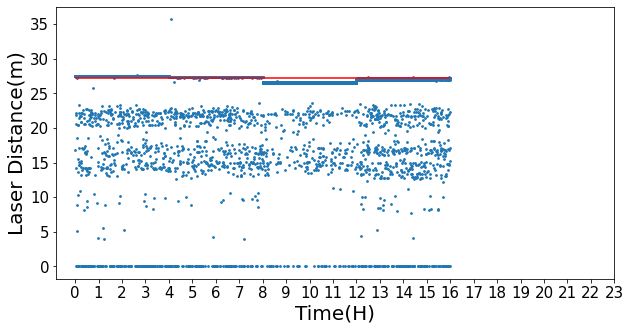

In [54]:
laser_id = theta_raw[8] == theta
azimuth_channel = int(np.around((30661/100)/0.2)) + 30
print(collector.aggregated_map[-3,laser_id,azimuth_channel])
print(azimuth_channel)
temp = collector.aggregated_map[:,laser_id,azimuth_channel]
# thred = get_thred_modified(temp.flatten(),1,0.125,10,0.001,0.5)
thred = threshold_map[laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(collector.aggregated_map)),collector.aggregated_map[:,laser_id,azimuth_channel],s = 3)
plt.hlines(thred,0,len(collector.aggregated_map),color = 'r')
# plt.ylim(49,52)
plt.xticks(np.arange(0,24000,1000),np.arange(0,24),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Laser Distance(m)',fontsize = 20)
plt.xlabel('Time(H)',fontsize = 20)
plt.show()

In [52]:
Td_map = collector.aggregated_map[-3]
Colored_map = np.full(Td_map.shape,0)
Colored_map[laser_id,1563:1573] = 1
pcd = get_pcd_colored_dir(Td_map,Colored_map)
draw(pcd)


WebVisualizer(window_uid='window_8')

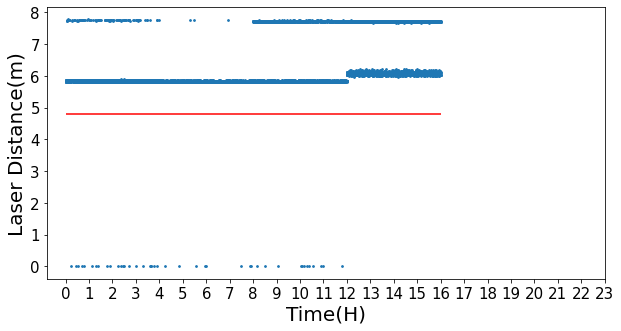

In [53]:

laser_id = theta_raw[28] == theta
azimuth_channel = int(np.around((20747/100)/0.2)) + 30
temp = collector.aggregated_map[:,laser_id,azimuth_channel]
thred = get_thred_modified(temp.flatten(),1,0.125,10,0.001,0.5)
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(collector.aggregated_map)),collector.aggregated_map[:,laser_id,azimuth_channel], s = 3)
plt.hlines(thred,0,len(collector.aggregated_map),color = 'r')
# plt.ylim(49,52)
plt.xticks(np.arange(0,24000,1000),np.arange(0,24),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Laser Distance(m)',fontsize = 20)
plt.xlabel('Time(H)',fontsize = 20)
plt.show()

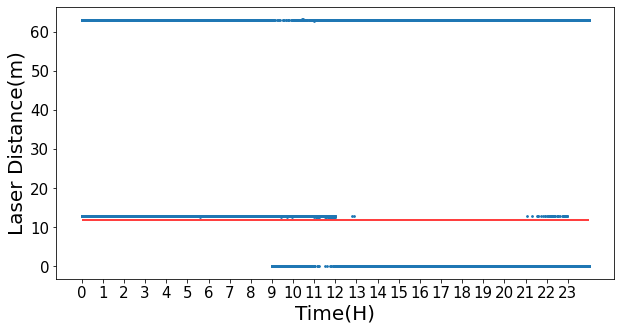

In [9]:

laser_id = theta_raw[14] == theta
azimuth_channel = int(np.around((13232/100)/0.2)) + 30
temp = collector.aggregated_map[:,laser_id,azimuth_channel]
thred = get_thred_modified(temp.flatten(),1,0.125,10,0.001,0.5)
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(collector.aggregated_map)),collector.aggregated_map[:,laser_id,azimuth_channel], s = 3)
plt.hlines(thred,0,len(collector.aggregated_map),color = 'r')
# plt.ylim(30,40)
plt.xticks(np.arange(0,24000,1000),np.arange(0,24),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Laser Distance(m)',fontsize = 20)
plt.xlabel('Time(H)',fontsize = 20)
plt.show()

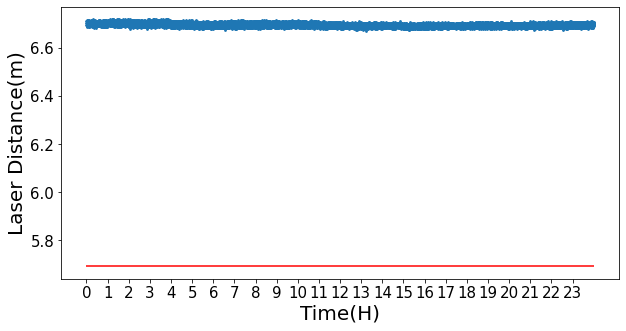

In [10]:

laser_id = theta_raw[31] == theta
azimuth_channel = int(np.around((22021/100)/0.2)) + 30
temp = collector.aggregated_map[:,laser_id,azimuth_channel]
thred = get_thred_modified(temp.flatten(),1,0.125,10,0.001,0.5)
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(collector.aggregated_map)),collector.aggregated_map[:,laser_id,azimuth_channel], s = 3)
plt.hlines(thred,0,len(collector.aggregated_map),color = 'r')
# plt.ylim(55,70)
plt.xticks(np.arange(0,24000,1000),np.arange(0,24),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Laser Distance(m)',fontsize = 20)
plt.xlabel('Time(H)',fontsize = 20)
plt.show()

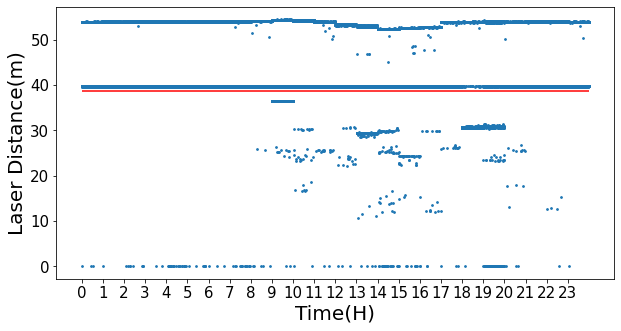

In [123]:

laser_id = theta_raw[2] == theta
azimuth_channel = int(np.around((25821/100)/0.2)) + 30
temp = collector.aggregated_map[:,laser_id,azimuth_channel]
thred = get_thred_modified(temp.flatten(),1,0.125,10,0.001,0.5)
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(collector.aggregated_map)),collector.aggregated_map[:,laser_id,azimuth_channel], s = 3)
plt.hlines(thred,0,len(collector.aggregated_map),color = 'r')
# plt.ylim(30,40)
plt.xticks(np.arange(0,24000,1000),np.arange(0,24),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Laser Distance(m)',fontsize = 20)
plt.xlabel('Time(H)',fontsize = 20)
plt.show()

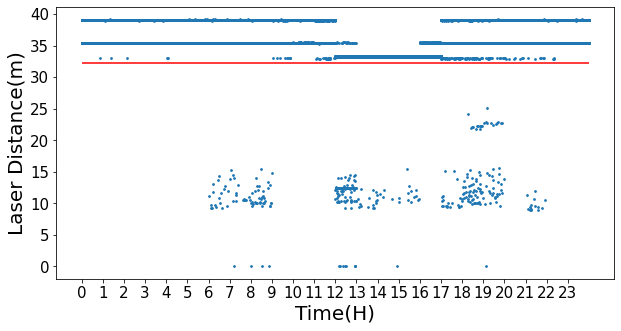

In [124]:

laser_id = theta_raw[14] == theta
azimuth_channel = int(np.around((3284/100)/0.2)) + 30
temp = collector.aggregated_map[:,laser_id,azimuth_channel]
thred = get_thred_modified(temp.flatten(),1,0.05,10,0.001,0.5)
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(collector.aggregated_map)),collector.aggregated_map[:,laser_id,azimuth_channel], s = 3)
plt.hlines(thred,0,len(collector.aggregated_map),color = 'r')
# plt.ylim(28,40)
plt.xticks(np.arange(0,24000,1000),np.arange(0,24),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Laser Distance(m)',fontsize = 20)
plt.xlabel('Time(H)',fontsize = 20)
plt.show()

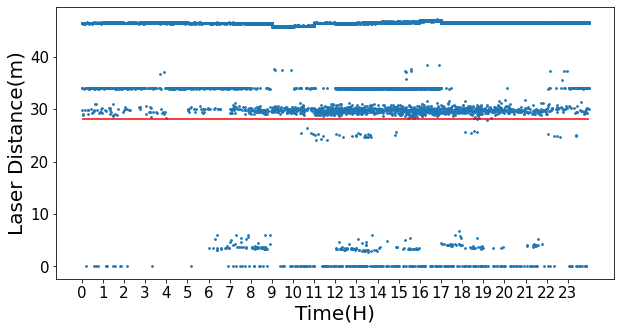

In [129]:

laser_id = theta_raw[20] == theta
azimuth_channel = int(np.around((12899/100)/0.2)) + 30
temp = collector.aggregated_map[:,laser_id,azimuth_channel]
thred = get_thred_modified(temp.flatten(),1,0.02,10,0.001,0.5)
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(collector.aggregated_map)),collector.aggregated_map[:,laser_id,azimuth_channel], s = 3)
plt.hlines(thred,0,len(collector.aggregated_map),color = 'r')
# plt.ylim(25,32)
plt.xticks(np.arange(0,24000,1000),np.arange(0,24),fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('Laser Distance(m)',fontsize = 20)
plt.xlabel('Time(H)',fontsize = 20)
plt.show()

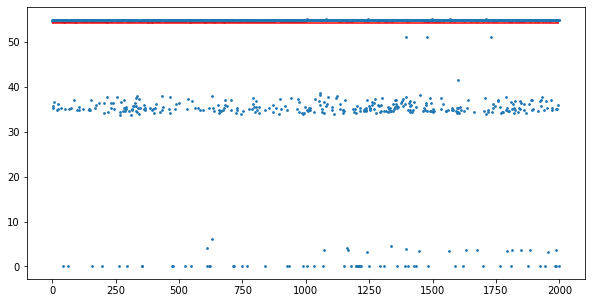

In [90]:
laser_id = theta_raw[24] == theta
azimuth_channel = 726
plt.figure(figsize=(10,5))
plt.scatter(np.arange(2000),collector.aggregated_map[:2000,laser_id,azimuth_channel], s = 3)
plt.hlines(threshold_map[laser_id,azimuth_channel],0,2000,color = 'r')
plt.show()

In [ ]:
laser_id = theta_raw[0] == theta
azimuth_channel = 726
plt.figure(figsize=(10,5))
plt.scatter(np.arange(2000),collector.aggregated_map[:2000,laser_id,azimuth_channel], s = 3)
plt.hlines(threshold_map[laser_id,azimuth_channel],0,2000,color = 'r')
plt.show()

In [38]:
data_path = r'D:\LiDAR_Data\MidTown\PCAP_BCK\Roundabout\24'

In [ ]:
laser_id = theta_raw[24] == theta
azimuth_channel = 726

In [ ]:
collector = RansacCollector(pcap_path=r'D:\LiDAR_Data\MidTown\Roundabout\2022-1-21-14-30-0.pcap',output_file_path='D:\LiDAR_Data\MidTown\Roundabout',update_frame_num=2000)
collector.gen_tdmap()

In [42]:

data_fs = os.listdir(data_path)
pcaps_list = [p for p in data_fs if 'pcap' in p.split('.')]
aggregated_maps_multiple = []
for i in range(len(pcaps_list)):
    collector = RansacCollector(pcap_path=os.path.join(data_path,pcaps_list[i]),output_file_path='D:\LiDAR_Data\MidTown\Roundabout',update_frame_num=2000)
    collector.gen_tdmap()
    aggregated_maps_multiple.append(collector.aggregated_map[:2000,laser_id,azimuth_channel])
    

Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.38it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:18<00:00, 25.62it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.92it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.24it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.84it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:18<00:00, 25.37it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.03it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:18<00:00, 25.58it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.92it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:18<00:00, 25.61it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.66it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.05it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:28<00:00, 22.51it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.03it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:20<00:00, 24.91it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:20<00:00, 24.91it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.29it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:20<00:00, 24.92it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:24<00:00, 23.77it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:24<00:00, 23.56it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:22<00:00, 24.25it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:23<00:00, 24.02it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:18<00:00, 25.51it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.74it/s]


In [113]:
aggragated_map = np.concatenate(aggregated_maps_multiple)

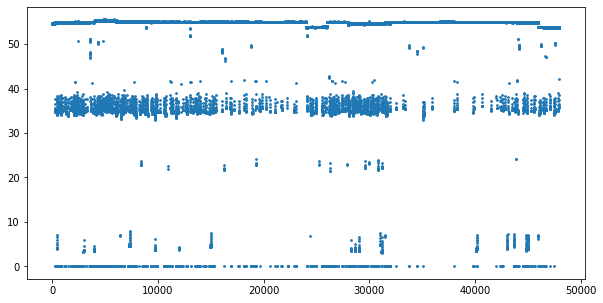

In [47]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 3)

In [57]:
def get_thred_modified(ts,d ,thred_s ,N ,delta_thred ,step):# Ransac Para
    ts_temp = ts.copy()
    ts_temp[ts_temp == 0] = 1000
    valid_dises = []
    for i in range(N):
        sample = np.random.choice(ts_temp,replace=False)
        set_d = ts_temp[(ts_temp > sample - d)&(ts_temp < sample + d)]
        condition_thred = len(set_d)/len(ts_temp) > thred_s
        if condition_thred :
            valid_dises.append(sample)
            
    if len(valid_dises) == 0:
        return 1000

    cur_thred = np.min(valid_dises)

    while True:
        next_thred = cur_thred - step
        if (len(ts[ts > next_thred])/len(ts) - len(ts[ts > cur_thred])/len(ts)) < delta_thred:
            break
        cur_thred = next_thred

    return next_thred

In [85]:
len(temp[(temp > 30)&(temp < 40)])/len(temp)

0.08314583333333334

In [81]:
thred = get_thred_modified(temp.flatten(),1,0.125,10,0.001,0.01)

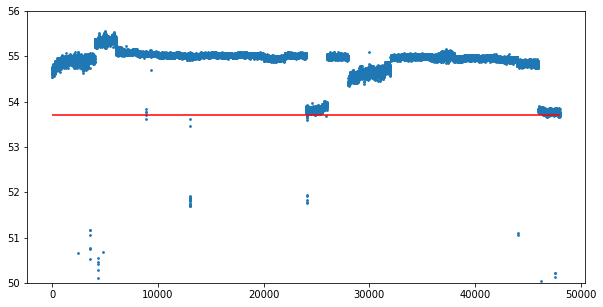

In [82]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp,s = 3)
plt.hlines(thred,0,len(temp),color = 'r')
plt.ylim(50,56)
plt.show()

In [202]:
thred = get_thred_modified(temp.flatten(),2,0.125,20,1e-3,0.05)

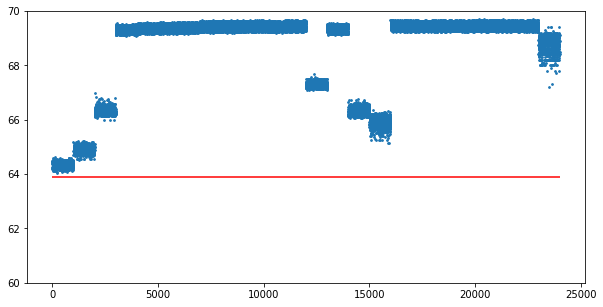

In [255]:
laser_id = theta_raw[31] == theta
azimuth_channel = 1102
temp = aggragated_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp, s = 3)
plt.hlines(thred,0,len(temp),color = 'r')
plt.ylim(60,70)
plt.show()

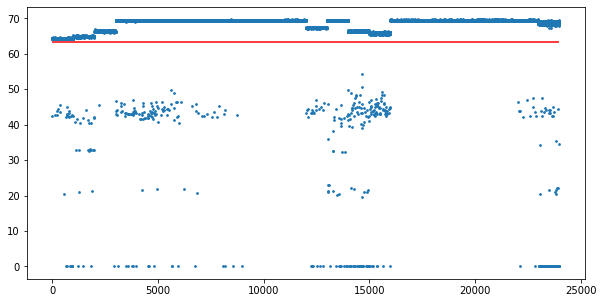

In [254]:
laser_id = theta_raw[31] == theta
azimuth_channel = 1102
temp = aggragated_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp, s = 3)
plt.hlines(threshold_map[laser_id,azimuth_channel],0,len(temp),color = 'r')
plt.show()

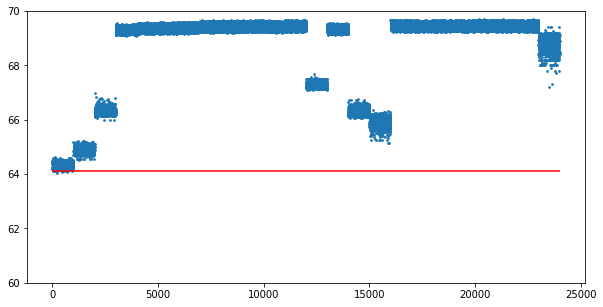

In [212]:
laser_id = theta_raw[31] == theta
azimuth_channel = 1102
temp = aggragated_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp, s = 3)
thred = get_thred_modified(temp.flatten(),2,0.125,20,1e-3,0.05)
plt.hlines(thred,0,len(temp),color = 'r')
plt.ylim(60,70)
plt.show()

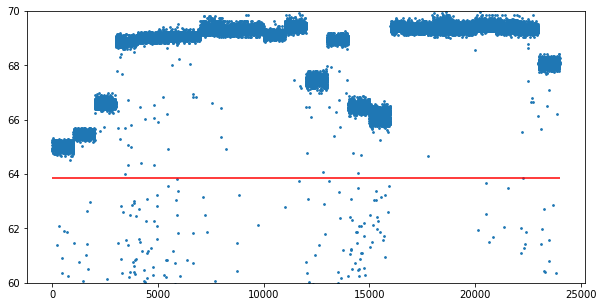

In [262]:
laser_id = theta_raw[31] == theta
azimuth_channel = 1075
temp = aggragated_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp, s = 3)
thred = get_thred_modified(temp.flatten(),2,0.05,20,1e-3,0.5)
plt.hlines(thred,0,len(temp),color = 'r')
plt.ylim(60,70)
plt.show()

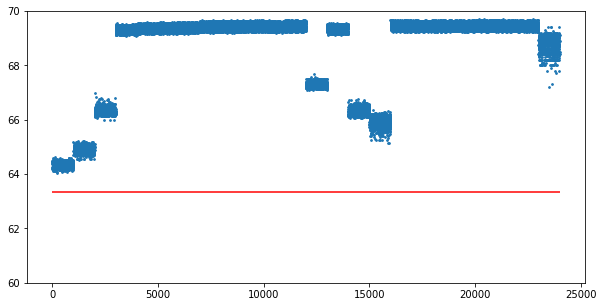

In [261]:
laser_id = theta_raw[31] == theta
azimuth_channel = 1102
temp = aggragated_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp, s = 3)
thred = get_thred_modified(temp.flatten(),2,0.05,20,1e-3,0.5)
plt.hlines(thred,0,len(temp),color = 'r')
plt.ylim(60,70)
plt.show()

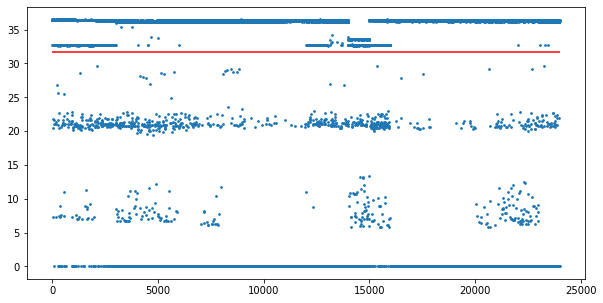

In [260]:
laser_id = theta_raw[19] == theta
azimuth_channel = int((4893/100)/0.2)
temp = aggragated_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp, s = 3)
thred = get_thred_modified(temp.flatten(),2,0.05,20,1e-3,0.5)
plt.hlines(thred,0,len(temp),color = 'r')
# plt.ylim(60,70)
plt.show()

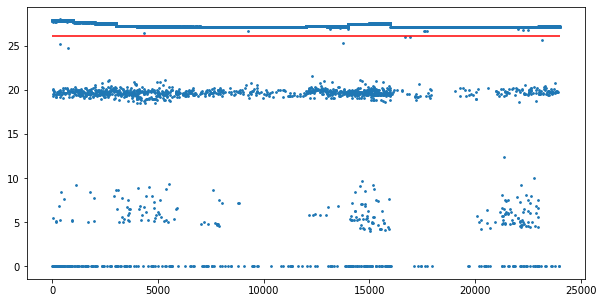

In [263]:
laser_id = theta_raw[12] == theta
azimuth_channel = int((6126/100)/0.2)
temp = aggragated_map[:,laser_id,azimuth_channel]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(temp)),temp, s = 3)
thred = get_thred_modified(temp.flatten(),2,0.05,20,1e-3,0.5)
plt.hlines(thred,0,len(temp),color = 'r')
# plt.ylim(60,70)
plt.show()